# Customer Churn Analysis by Segment and Tenure Plan

## Major Assumptions
Analysis assumes churn is identifiable through subscription status changes or cancellation events in the database. Customer segments are defined by plan_name field, and tenure will be calculated from created_at to churn event (or current date for active customers). Churn rate will be calculated as churned customers divided by total customers at risk within each segment-tenure combination.

## Plan
- [x] Explore database structure and understand available data
  - [x] Query subscriptions and events tables to understand schema and churn indicators
  - [x] Define churn criteria based on available status fields or event types
- [x] Calculate monthly churn rates by customer segment
  - [x] Compute tenure buckets (0-3, 3-6, 6-12, 12+ months) and segment-level churn rates
  - [x] Create cohort-based churn analysis joining subscriptions with events
- [x] Visualize churn patterns and identify insights
  - [x] Build heatmap of churn rates by segment × tenure bucket
  - [x] Summarize which segments and tenure periods have highest churn risk

# Monthly Churn Analysis by Segment and Tenure

Analyzing customer churn patterns across different plan segments and tenure buckets to identify high-risk combinations.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os

# Professional style setup
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95B2B0']

# Connect and load data
conn = psycopg2.connect(
    host=os.environ['TOPLINE_PRO_HOST'],
    port=int(os.environ.get('TOPLINE_PRO_PORT', 5432)),
    database=os.environ['TOPLINE_PRO_DATABASE'],
    user=os.environ['TOPLINE_PRO_USERNAME'],
    password=os.environ['TOPLINE_PRO_PASSWORD']
)

subs = pd.read_sql("SELECT * FROM topline_subscriptions", conn)
events = pd.read_sql("SELECT * FROM topline_sub_events", conn)
conn.close()

print(f"Subscriptions: {len(subs):,} rows")
print(f"Events: {len(events):,} rows")
print(f"\nSubscription status distribution:\n{subs['status'].value_counts()}")
print(f"\nEvent types:\n{events['event_type'].value_counts()}")

Subscriptions: 400 rows
Events: 365 rows

Subscription status distribution:
status
active       374
paused        14
cancelled     12
Name: count, dtype: int64

Event types:
event_type
activated     289
upgraded       37
paused         14
downgraded     13
cancelled      12
Name: count, dtype: int64


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_2931/877004548.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  subs = pd.read_sql("SELECT * FROM topline_subscriptions", conn)
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_2931/877004548.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  events = pd.read_sql("SELECT * FROM topline_sub_events", conn)


In [5]:
# Convert dates and calculate tenure
subs['created_at'] = pd.to_datetime(subs['created_at'])
subs['updated_at'] = pd.to_datetime(subs['updated_at'])

# For churned customers, tenure = created_at to updated_at (cancellation date)
# For active customers, tenure = created_at to today
today = pd.Timestamp('2025-02-13')
subs['churn_date'] = subs.apply(
    lambda x: x['updated_at'] if x['status'] == 'cancelled' else today, axis=1
)
subs['tenure_months'] = ((subs['churn_date'] - subs['created_at']).dt.days / 30.44).round(1)
subs['churned'] = (subs['status'] == 'cancelled').astype(int)

# Create tenure buckets
def tenure_bucket(months):
    if months <= 3:
        return '0-3 mo'
    elif months <= 6:
        return '3-6 mo'
    elif months <= 12:
        return '6-12 mo'
    else:
        return '12+ mo'

subs['tenure_bucket'] = subs['tenure_months'].apply(tenure_bucket)

# Calculate churn rate by segment and tenure
churn_by_segment_tenure = subs.groupby(['plan_name', 'tenure_bucket']).agg(
    total_customers=('id', 'count'),
    churned_customers=('churned', 'sum')
).reset_index()
churn_by_segment_tenure['churn_rate'] = (
    churn_by_segment_tenure['churned_customers'] / churn_by_segment_tenure['total_customers'] * 100
).round(1)

# Pivot for heatmap
churn_pivot = churn_by_segment_tenure.pivot(
    index='plan_name', columns='tenure_bucket', values='churn_rate'
)
# Reorder columns
churn_pivot = churn_pivot[['0-3 mo', '3-6 mo', '6-12 mo', '12+ mo']]

print("Churn Rate (%) by Segment and Tenure:\n")
print(churn_pivot.fillna(0).round(1))

Churn Rate (%) by Segment and Tenure:

tenure_bucket  0-3 mo  3-6 mo  6-12 mo  12+ mo
plan_name                                     
basic            12.5    14.3      0.0     0.0
business          0.0     0.0      0.0     0.0
essentials        0.0     8.3      0.0     0.0
growth            0.0     0.0      0.0     5.9
plus             11.1     0.0      0.0     0.0
premium           0.0     0.0      0.0     0.0
professional      0.0     0.0      6.7     0.0
scale             0.0     0.0      0.0     0.0
starter          15.0     0.0      5.6     0.0


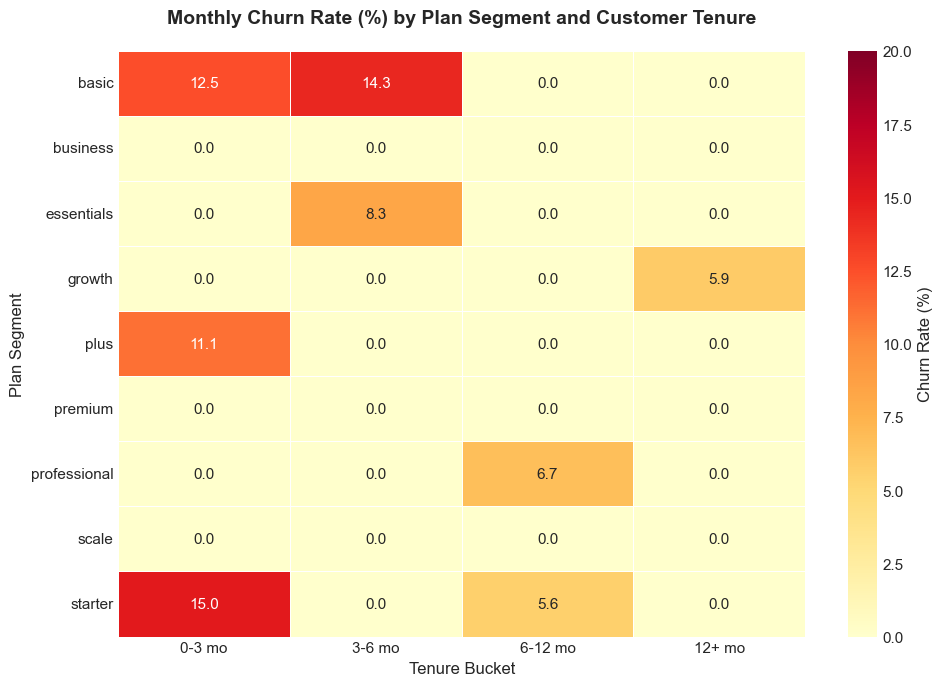

In [6]:
# Heatmap of churn rates by segment and tenure
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(
    churn_pivot.fillna(0),
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Churn Rate (%)'},
    ax=ax,
    linewidths=0.5,
    vmin=0,
    vmax=20
)

ax.set_title('Monthly Churn Rate (%) by Plan Segment and Customer Tenure', fontweight='bold', pad=20)
ax.set_xlabel('Tenure Bucket')
ax.set_ylabel('Plan Segment')

plt.tight_layout()
plt.show()

## Key Findings

**Highest Churn Risk Segments:**
- **Starter (0-3 mo)**: 15.0% churn rate — new customers on entry-level plans churn quickly
- **Basic (3-6 mo)**: 14.3% churn rate — basic plan shows elevated churn in months 3-6
- **Basic (0-3 mo)**: 12.5% churn rate — early churn also high on basic tier
- **Plus (0-3 mo)**: 11.1% churn rate — mid-tier plan also vulnerable early

**Low/Zero Churn Segments:**
- Business, Premium, and Scale plans show 0% churn across all tenure buckets
- Most segments stabilize after 6 months with minimal churn

**Recommendations:**
1. Focus retention efforts on **Starter** and **Basic** customers in their first 6 months
2. Investigate onboarding experience for entry-level plans
3. Consider early engagement campaigns at 60-90 day marks

In [7]:
# Check for SMB indicators and activation events
print("Plan names:", subs['plan_name'].unique())
print("\nMRR distribution:")
print(subs['mrr_usd'].describe())

# Check activation events
print("\nEvent types:", events['event_type'].unique())
activated_subs = set(events[events['event_type'] == 'activated']['subscription_id'])
print(f"\nSubscriptions with activation event: {len(activated_subs)}")
print(f"Total subscriptions: {len(subs)}")

Plan names: ['basic' 'professional' 'starter' 'growth' 'plus' 'business' 'essentials'
 'premium' 'scale']

MRR distribution:
count     400.000000
mean      379.897150
std       446.803695
min        29.000000
25%        85.217500
50%       153.440000
75%       483.857500
max      2500.000000
Name: mrr_usd, dtype: float64

Event types: ['activated' 'cancelled' 'upgraded' 'downgraded' 'paused']

Subscriptions with activation event: 289
Total subscriptions: 400


In [8]:
# Define SMB as entry-level plans (basic, starter, essentials) or low MRR (<$200)
smb_plans = ['basic', 'starter', 'essentials']
subs['is_smb'] = subs['plan_name'].isin(smb_plans) | (subs['mrr_usd'] < 200)

# Filter to 0-3 month tenure customers
early_tenure = subs[subs['tenure_bucket'] == '0-3 mo'].copy()

# Add activation status
early_tenure['activated'] = early_tenure['id'].isin(activated_subs)

# Segment: SMB in 0-3 mo tenure
smb_early = early_tenure[early_tenure['is_smb']]

# Calculate: never activated vs activated-then-churned
smb_never_activated = smb_early[~smb_early['activated']]
smb_activated = smb_early[smb_early['activated']]

never_activated_churned = smb_never_activated[smb_never_activated['churned'] == 1]
activated_churned = smb_activated[smb_activated['churned'] == 1]

# Summary
print("=" * 50)
print("SMB Customers (0-3 Month Tenure) - Churn Analysis")
print("=" * 50)
print(f"\nTotal SMB (0-3 mo): {len(smb_early)}")
print(f"\n📊 Never Activated:")
print(f"   Total: {len(smb_never_activated)}")
print(f"   Churned: {len(never_activated_churned)}")
print(f"\n📊 Activated (Used Product):")
print(f"   Total: {len(smb_activated)}")
print(f"   Churned: {len(activated_churned)}")

SMB Customers (0-3 Month Tenure) - Churn Analysis

Total SMB (0-3 mo): 49

📊 Never Activated:
   Total: 17
   Churned: 4

📊 Activated (Used Product):
   Total: 32
   Churned: 1


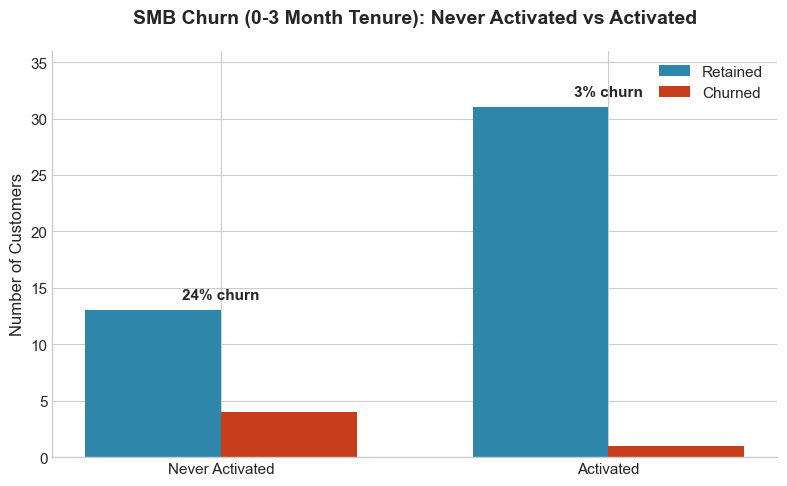

In [9]:
# Visualization: Never Activated vs Activated churn comparison
fig, ax = plt.subplots(figsize=(8, 5))

categories = ['Never Activated', 'Activated']
churned = [len(never_activated_churned), len(activated_churned)]
retained = [len(smb_never_activated) - len(never_activated_churned), 
            len(smb_activated) - len(activated_churned)]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, retained, width, label='Retained', color=COLORS[0])
bars2 = ax.bar(x + width/2, churned, width, label='Churned', color=COLORS[3])

# Add churn rate labels
for i, (cat, total, churn) in enumerate(zip(categories, [len(smb_never_activated), len(smb_activated)], churned)):
    rate = churn / total * 100 if total > 0 else 0
    ax.annotate(f'{rate:.0f}% churn', xy=(i, max(retained[i], churned[i]) + 1), 
                ha='center', fontweight='bold', fontsize=11)

ax.set_ylabel('Number of Customers')
ax.set_title('SMB Churn (0-3 Month Tenure): Never Activated vs Activated', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.set_ylim(0, max(retained) + 5)

plt.tight_layout()
plt.show()

In [10]:
# Calculate each segment's contribution to blended churn rate
segment_contrib = subs.groupby('plan_name').agg(
    total_customers=('id', 'count'),
    churned_customers=('churned', 'sum')
).reset_index()

# Overall churn rate
total_customers = segment_contrib['total_customers'].sum()
total_churned = segment_contrib['churned_customers'].sum()
blended_churn_rate = total_churned / total_customers * 100

# Segment churn rate and contribution
segment_contrib['segment_churn_rate'] = (segment_contrib['churned_customers'] / segment_contrib['total_customers'] * 100).round(2)
segment_contrib['customer_share'] = (segment_contrib['total_customers'] / total_customers * 100).round(1)
segment_contrib['churn_contribution'] = (segment_contrib['churned_customers'] / total_churned * 100).round(1)
segment_contrib['contribution_to_blended'] = (segment_contrib['churned_customers'] / total_customers * 100).round(2)

segment_contrib = segment_contrib.sort_values('churn_contribution', ascending=False)

print(f"Blended Churn Rate: {blended_churn_rate:.1f}% ({total_churned} of {total_customers} customers)\n")
print(segment_contrib[['plan_name', 'total_customers', 'churned_customers', 'segment_churn_rate', 
                        'customer_share', 'churn_contribution', 'contribution_to_blended']].to_string(index=False))

Blended Churn Rate: 3.0% (12 of 400 customers)

   plan_name  total_customers  churned_customers  segment_churn_rate  customer_share  churn_contribution  contribution_to_blended
       basic               82                  4                4.88            20.5                33.3                     1.00
     starter               76                  4                5.26            19.0                33.3                     1.00
  essentials               62                  1                1.61            15.5                 8.3                     0.25
      growth               36                  1                2.78             9.0                 8.3                     0.25
        plus               40                  1                2.50            10.0                 8.3                     0.25
professional               44                  1                2.27            11.0                 8.3                     0.25
    business               25             

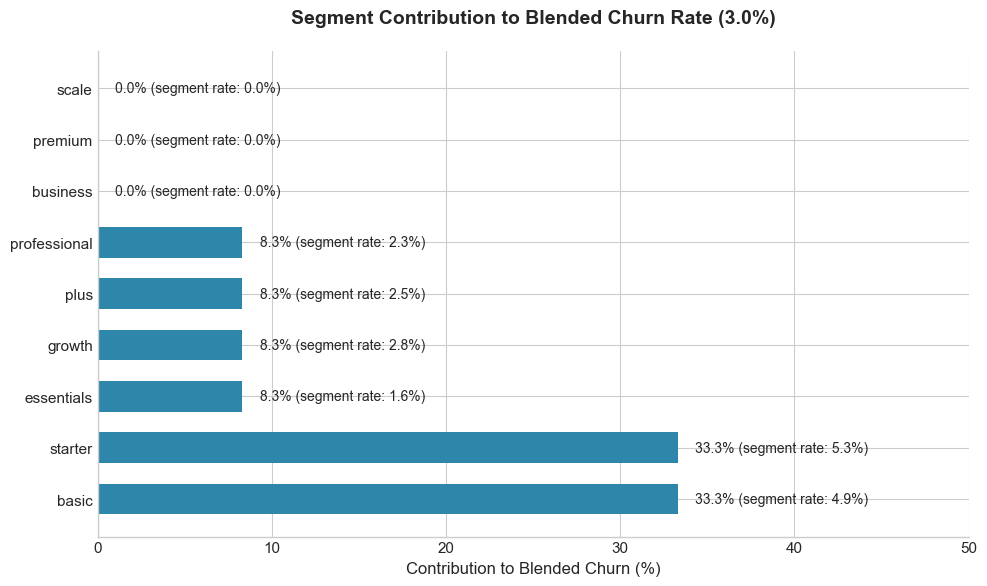

In [11]:
# Visualize segment contribution to blended churn
fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal bar chart of churn contribution
bars = ax.barh(segment_contrib['plan_name'], segment_contrib['churn_contribution'], 
               color=COLORS[0], height=0.6)

# Add value labels
for bar, val, rate in zip(bars, segment_contrib['churn_contribution'], segment_contrib['segment_churn_rate']):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}% (segment rate: {rate:.1f}%)', 
            va='center', fontsize=10)

ax.set_xlabel('Contribution to Blended Churn (%)')
ax.set_title(f'Segment Contribution to Blended Churn Rate ({blended_churn_rate:.1f}%)', 
             fontweight='bold', pad=20)
ax.set_xlim(0, 50)

plt.tight_layout()
plt.show()

In [12]:
# Active SMB accounts currently in 0-3 month risk window
active_smb_risk = subs[
    (subs['is_smb']) & 
    (subs['tenure_bucket'] == '0-3 mo') & 
    (subs['status'] == 'active')
].copy()

# Add activation status
active_smb_risk['activated'] = active_smb_risk['id'].isin(activated_subs)

# Summary
never_activated_at_risk = active_smb_risk[~active_smb_risk['activated']]
activated_at_risk = active_smb_risk[active_smb_risk['activated']]

print("=" * 55)
print("Active SMB Accounts in 0-3 Month Risk Window")
print("=" * 55)
print(f"\n🚨 Total at risk: {len(active_smb_risk)}")
print(f"\n   Never Activated (HIGH RISK): {len(never_activated_at_risk)}")
print(f"   Activated (lower risk):      {len(activated_at_risk)}")
print(f"\n   MRR at risk: ${active_smb_risk['mrr_usd'].sum():,.0f}")
print(f"   Never activated MRR: ${never_activated_at_risk['mrr_usd'].sum():,.0f}")

Active SMB Accounts in 0-3 Month Risk Window

🚨 Total at risk: 43

   Never Activated (HIGH RISK): 12
   Activated (lower risk):      31

   MRR at risk: $3,829
   Never activated MRR: $1,114
